## C.5 実装コード

In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

In [6]:
# ハイパーパラメータの設定
input_dim = 784 # 入力次元数：28x28=784
hidden_dim = 100 # 隠れ層の次元数
latent_dim = 20 # 潜在変数の次元数
epochs = 30
learning_rate = 1e-3
batch_size = 32

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc(x))
        mean = self.fc_mean(h)
        log_var = self.fc_var(h)
        sigma = torch.exp(log_var * 0.5)
        return mean, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        h = F.relu(self.fc1(x))
        x = self.fc2(h)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x

In [8]:
def reparametrize(mean, sigma):
    epsilon = torch.randn_like(sigma)
    return mean + sigma * epsilon

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim) # q(z_1|x)
        self.encoder2 = Encoder(input_dim, hidden_dim, latent_dim) # q(z_2|z_1)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True) # p(x|z_1)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim) # p(z_1|z_2)

    def get_loss(self, x):
        mu1, sigma1 = self.encoder1(x)
        z1 = reparametrize(mu1, sigma1)

        mu2, sigma2 = self.encoder2(x)
        z2 = reparametrize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = -torch.sum(1 + torch.log(sigma2**2) - mu2**2 - sigma2**2)
        L3 = -torch.sum(1 + torch.log(sigma1**2) - (mu1 - z_hat)**2 - sigma1**2)

        return (L1 + L2 + L3) / batch_size

In [9]:
# gpuを使う
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0
    cnt = 0

    for x, label in dataloader:
        x = x.to(device)
        loss = model.get_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    losses.append(loss_sum / cnt)
    print(f'epoch: {epoch+1}, loss: {loss_sum / cnt}')

epoch: 1, loss: 50.02223530476888
epoch: 2, loss: 43.322579787190755
epoch: 3, loss: 41.58580562133789
epoch: 4, loss: 40.87611138916016
epoch: 5, loss: 40.455920438639325
epoch: 6, loss: 40.16200491943359
epoch: 7, loss: 40.00286949869792
epoch: 8, loss: 39.89443435465495
epoch: 9, loss: 39.697477146402996
epoch: 10, loss: 39.62506366170248
epoch: 11, loss: 39.56466528523763
epoch: 12, loss: 39.51263857014974
epoch: 13, loss: 39.42237477213542
epoch: 14, loss: 39.319434079996746
epoch: 15, loss: 39.33379388834636
epoch: 16, loss: 39.25909812825521
epoch: 17, loss: 39.225667338053384
epoch: 18, loss: 39.186207792154946
epoch: 19, loss: 39.191907224527995
epoch: 20, loss: 39.09543638712565
epoch: 21, loss: 39.11034548339844
epoch: 22, loss: 39.060195790608724
epoch: 23, loss: 39.03254617513021
epoch: 24, loss: 39.0188147664388
epoch: 25, loss: 39.01351578877767
epoch: 26, loss: 38.94746305135091
epoch: 27, loss: 38.94103339640299
epoch: 28, loss: 38.948684405517575
epoch: 29, loss: 38.9

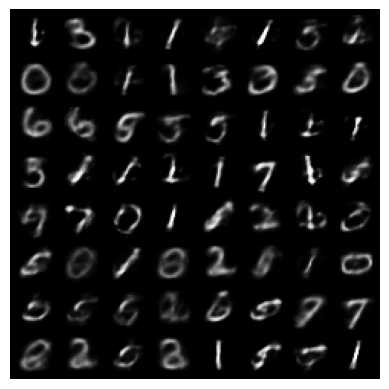

In [14]:
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    x_hat = model.decoder1(z)
    x_hat = x_hat.view(-1, 1, 28, 28).cpu().numpy()

grid_img = torchvision.utils.make_grid(torch.tensor(x_hat), nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()